In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%capture
%pip install torch torchvision
%pip install accelerate
%pip install transformers
%pip install transformers[torch]
%pip install datasets
%pip install errant

In [3]:
from collections import namedtuple

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import spacy
import errant

In [14]:
TEST_JSON_PATH = '/content/drive/MyDrive/CS4248/datasets/test.json'
TEST_M2_PATH = '/content/drive/MyDrive/CS4248/datasets/test.m2'
OUT_M2_PATH = '/content/drive/MyDrive/CS4248/out.m2'

MODEL_PATH = '/content/drive/MyDrive/results_t5_small/checkpoint-3500'
T5_MODEL = 't5-small'

TASK_PREFIX = 'rectify'
TOKENIZER_PADDING = 'max_length'
SOURCE_MAX_LENGTH = 512
GEN_MAX_LENGTH = 512
GEN_NUM_BEAMS = 5

In [12]:
dataset_test = load_dataset('json', data_files=TEST_JSON_PATH, split='train')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Model to be tested
model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH)
t5_tokenizer = T5Tokenizer.from_pretrained(T5_MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [16]:
nlp = spacy.load("en_core_web_sm")
spacy_tokenizer = nlp.tokenizer
annotator = errant.load('en', nlp)

In [17]:
def generate_correction(model, tokenizer, sample):
    input_text = f"{TASK_PREFIX}: {sample['original']}"
    inputs = t5_tokenizer.encode(
        input_text,
        max_length=SOURCE_MAX_LENGTH,
        padding=TOKENIZER_PADDING,
        truncation=True,
        return_tensors='pt',
    )
    corrected_ids = model.generate(
        inputs.cuda(),
        max_length=GEN_MAX_LENGTH,
        num_beams=GEN_NUM_BEAMS,
        early_stopping=True,
    )
    corrected_sentence = tokenizer.decode(
        corrected_ids[0],
        skip_special_tokens=True,
    )
    # Retokenize sentence using spacy to restore correct spacing between tokens
    # for accurate error correction score calculation
    corrected_sentence = ' '.join(tok.text for tok in spacy_tokenizer(corrected_sentence))
    return corrected_sentence

In [18]:
NOOP_EDIT = 'A -1 -1|||noop|||-NONE-|||REQUIRED|||-NONE-|||0'

with open(OUT_M2_PATH, 'w') as f:
    for sample in dataset_test:
        orig = sample['original']
        corrected = generate_correction(model, t5_tokenizer, sample)
        edits = annotator.annotate(annotator.parse(orig), annotator.parse(corrected))
        print('S', orig, file=f)
        if not edits:
            print(NOOP_EDIT, file=f)
        for edit in edits:
            print(edit.to_m2(), file=f)
        print(file=f)  # Blank divider line

In [19]:
# Compare output edits with gold-standard edits and computes statistics
!errant_compare -hyp {OUT_M2_PATH} -ref {TEST_M2_PATH}


=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
1344	1387	6110	0.4921	0.1803	0.3657



In [49]:
EDIT_OPS = {'M': 'Missing', 'U': 'Unnecessary', 'R': 'Replacement'}
NOOP_EDIT_TYPE = 'noop'
UNK_EDIT_TYPE = 'UNK'
EDIT_TYPES = [
    'ADJ', 'ADJ:FORM', 'ADV', 'CONJ', 'CONTR', 'DET', 'MORPH',
    'NOUN', 'NOUN:INFL', 'NOUN:NUM', 'NOUN:POSS',
    'ORTH', 'OTHER', 'PART', 'PREP', 'PRON', 'PUNCT', 'SPELL',
    'VERB', 'VERB:FORM', 'VERB:INFL', 'VERB:SVA', 'VERB:TENSE', 'WO',
]

Edit = namedtuple('Edit', ['span', 'code', 'correction'])

In [26]:
def load_edits(m2_file_path):
    edits = []
    with open(m2_file_path, 'r') as f:
        for group in f.read().split('\n\n'):
            if not group:
                continue
            sentence, *sent_edits = group.split('\n')
            edits.append([Edit(*e[2:].split('|||')[:3]) for e in sent_edits])
    return edits

In [39]:
def create_error_count_df(gold_edits, output_edits):
    rows = [*EDIT_OPS.values(), *EDIT_TYPES, NOOP_EDIT_TYPE, UNK_EDIT_TYPE]
    df = pd.DataFrame(0, index=rows, columns=['TP', 'FP', 'FN'])
    for gold_sent_edits, output_sent_edits in zip(gold_edits, output_edits):
        gold_set = set(gold_sent_edits)
        out_set = set(output_sent_edits)
        classified_edits = {
            'TP': gold_set & out_set,
            'FP': out_set - gold_set,
            'FN': gold_set - out_set
        }
        for outcome, edits in classified_edits.items():
            for edit in edits:
                if edit.code in (NOOP_EDIT_TYPE, UNK_EDIT_TYPE):
                    df.loc[edit.code, outcome] += 1
                else:
                    op, type_ = edit.code.split(':', maxsplit=1)
                    df.loc[EDIT_OPS[op], outcome] += 1
                    df.loc[type_, outcome] += 1
    df['P'] = df['TP'] / (df['TP'] + df['FP'])
    df['R'] = df['TP'] / (df['TP'] + df['FN'])
    df['F0.5'] = (1 + 0.5**2) * ((df['P'] * df['R']) / (0.5**2 * df['P'] + df['R']))
    return df

In [27]:
gold_edits = load_edits(TEST_M2_PATH)
output_edits = load_edits(OUT_M2_PATH)

In [50]:
error_df = create_error_count_df(gold_edits, output_edits)
error_df

,TP,FP,FN,P,R,F0.5
Missing,494,359,1515,0.579132,0.245893,0.455635
Unnecessary,125,255,654,0.328947,0.160462,0.271857
Replacement,725,773,3941,0.483979,0.155379,0.340120
ADJ,3,20,116,0.130435,0.025210,0.071090
ADJ:FORM,1,1,10,0.500000,0.090909,0.263158
ADV,5,27,118,0.156250,0.040650,0.099602
CONJ,3,3,45,0.500000,0.062500,0.208333
CONTR,3,4,27,0.428571,0.100000,0.258621
DET,99,98,709,0.502538,0.122525,0.310150
MORPH,27,35,152,0.435484,0.150838,0.316159


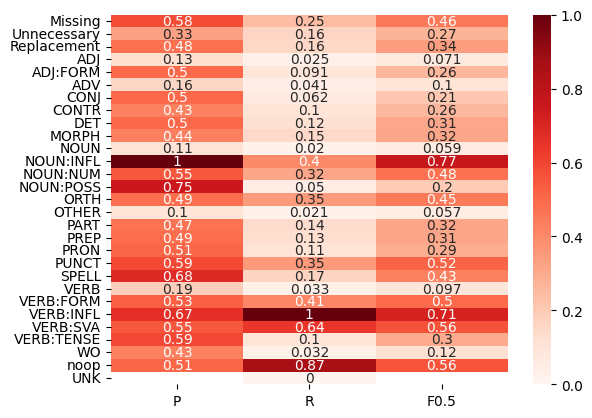

In [51]:
sns.heatmap(error_df[['P', 'R', 'F0.5']], vmin=0.0, vmax=1.0, cmap='Reds', annot=True, yticklabels=True)
plt.show()